In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras import Model
from tensorflow.keras.losses import categorical_crossentropy,sparse_categorical_crossentropy
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow import keras

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import wget


In [3]:
wget.download(r"https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py")

'helper_functions.py'

In [2]:
from tensorflow.keras import mixed_precision

In [3]:
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 2070 with Max-Q Design, compute capability 7.5


In [4]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 2070 with Max-Q Design (UUID: GPU-73d78d0a-ed4f-5a0d-2e4a-f6912777f8fc)


In [5]:
from helper_functions import plot_loss_curves,compare_historys

## Use tensorflow Dataset

In [6]:
import tensorflow_datasets as tfds

C:\Users\GEORGE\anaconda4\envs\tf-latest3\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
datasets_list = tfds.list_builders()

In [8]:
"food101" in datasets_list

True

## Load data

In [9]:
(train_data,test_data),ds_info = tfds.load(name="food101",split=["train",'validation'],
                                             shuffle_files=True,
                                             as_supervised=True,
                                             with_info=True)

In [10]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [11]:
# get the class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [12]:
# Take on sample
train_one_sample = train_data.take(1)


In [13]:
train_one_sample

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [14]:
# get image

for image,label in train_one_sample:
    print(f"""
    Image shape:{image.shape},
    Image datatype:{image.dtype},
    Target class from food101(tensorf form):{label},
    class name (str form):{class_names[label.numpy()]}
    """)


    Image shape:(341, 512, 3),
    Image datatype:<dtype: 'uint8'>,
    Target class from food101(tensorf form):98,
    class name (str form):tiramisu
    


In [45]:
# our image tensorf from TFDS

In [15]:
tf.reduce_min(image),tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

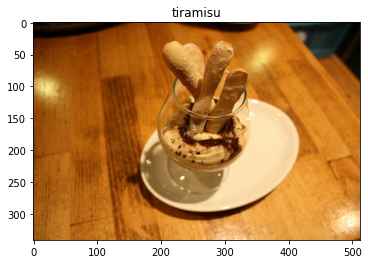

In [16]:
## plot image
plt.imshow(tf.cast(image,'float32')/255.)
plt.title(class_names[label.numpy()]);

## Create preprocessing functions for our data

In [17]:
from helper_functions import pre

ImportError: cannot import name 'pre' from 'helper_functions' (E:\jupyter\udemy\ztm_Tensor\foodVision\helper_functions.py)

In [18]:
def prep_img(image,label,img_shape=224):
    img = tf.image.resize(image,[img_shape,img_shape])
    return tf.cast(img,'float32'),label
    

In [19]:
prep_img(image,label)[0]

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[2.00000000e+00, 2.00000000e+00, 0.00000000e+00],
        [2.94722605e+00, 2.94722605e+00, 9.47225988e-01],
        [4.00000000e+00, 5.00000000e+00, 0.00000000e+00],
        ...,
        [1.00000000e+00, 3.00000000e+00, 0.00000000e+00],
        [1.86577532e-02, 2.75749707e+00, 0.00000000e+00],
        [0.00000000e+00, 4.00000000e+00, 0.00000000e+00]],

       [[4.35044622e+00, 5.13392830e+00, 7.83482075e-01],
        [4.56696415e+00, 5.35044622e+00, 1.00000000e+00],
        [4.78348207e+00, 5.78348207e+00, 7.83482075e-01],
        ...,
        [1.00000000e+00, 3.00000000e+00, 0.00000000e+00],
        [7.98950493e-01, 2.79895043e+00, 0.00000000e+00],
        [0.00000000e+00, 4.27984238e+00, 2.79842347e-01]],

       [[1.15290184e+01, 9.91741180e+00, 3.69419622e+00],
        [1.12450581e+01, 9.63345051e+00, 3.41023540e+00],
        [1.05290184e+01, 8.91741180e+00, 2.82525516e+00],
        ...,
        [2.00000000e+00, 2.00000

## batch and prepare dataset in tensordata using Pipeline

In [20]:
train_data = train_data.map(map_func=prep_img,num_parallel_calls=tf.data.AUTOTUNE)
# shuffle train data turn to baches

train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)#.cache()

# map to test data

test_data = test_data.map(map_func=prep_img,num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)#.cache()





In [21]:
train_data,test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

## Create model callback

In [22]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

In [23]:
checkpoint_path = r"check/model_vision101.h5"
model_checkpoint = ModelCheckpoint(checkpoint_path,save_best_only=True)

## Setup mixed precision training

In [24]:
from tensorflow.keras import mixed_precision

In [25]:
mixed_precision.set_global_policy('mixed_float16')

In [26]:
mixed_precision.global_policy()

<Policy "mixed_float16">

## Create model with mixed precision training

In [27]:
from tensorflow.keras.applications import EfficientNetB3

In [28]:
from tensorflow.keras.layers import Input

In [29]:
from tensorflow.keras.layers.experimental import preprocessing

In [30]:
base_model = EfficientNetB3(include_top=False)
base_model.trainable=False

inputs = Input(shape=[224,224,3],name='input_layer')
x = base_model(inputs,training=False)
# x = preprocessing.Rescaling(1/255.)(x) jika bukan effnet
x = GlobalAveragePooling2D()(x)
outputs = Dense(len(ds_info.features["label"].names),activation='softmax',dtype=tf.float32)(x)

model_food101 = Model(inputs,outputs)

In [31]:
model_food101.compile(loss=sparse_categorical_crossentropy,optimizer=Adam(),metrics=['accuracy'])

In [32]:
model_food101.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb3 (Functional)  (None, None, None, 1536)  10783535 
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 101)               155237    
                                                                 
Total params: 10,938,772
Trainable params: 155,237
Non-trainable params: 10,783,535
_________________________________________________________________


## Check layer dtype policy

In [33]:
for layer in model_food101.layers:
    print(layer.name,layer.dtype,layer.dtype_policy)

input_layer float32 <Policy "float32">
efficientnetb3 float32 <Policy "mixed_float16">
global_average_pooling2d float32 <Policy "mixed_float16">
dense float32 <Policy "float32">


## fit the feature extraction model

In [34]:
history_101_food_classes_feature = model_food101.fit(train_data,
                                                    epochs=3,
                                                    steps_per_epoch=len(train_data),
                                                    validation_data=test_data,
                                                    validation_steps=int(0.15* len(test_data)),
                                                    callbacks=[model_checkpoint])

Epoch 1/3
2368/2368 [==============================] - 219s 85ms/step - loss: 1.7778 - accuracy: 0.5621 - val_loss: 1.2395 - val_accuracy: 0.6687
Epoch 2/3
2368/2368 [==============================] - 200s 84ms/step - loss: 1.2743 - accuracy: 0.6687 - val_loss: 1.1566 - val_accuracy: 0.6886
Epoch 3/3
2368/2368 [==============================] - 202s 85ms/step - loss: 1.1186 - accuracy: 0.7051 - val_loss: 1.1316 - val_accuracy: 0.6962


In [35]:
result_feature_extract_model = model_food101.evaluate(test_data)
result_feature_extract_model

790/790 [==============================] - 60s 75ms/step - loss: 1.1286 - accuracy: 0.6947


[1.1285696029663086, 0.6946930885314941]

In [37]:
# Clone the model we created (this resets all weights)
cloned_model = tf.keras.models.clone_model(model_food101)
cloned_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb3 (Functional)  (None, None, None, 1536)  10783535 
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 101)               155237    
                                                                 
Total params: 10,938,772
Trainable params: 155,237
Non-trainable params: 10,783,535
_________________________________________________________________


In [38]:
cloned_model.load_weights(checkpoint_path)

In [39]:
# Compile cloned_model (with same parameters as original model)
cloned_model.compile(loss="sparse_categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [40]:
# Evalaute cloned model with loaded weights (should be same score as trained model)
results_cloned_model_with_loaded_weights = cloned_model.evaluate(test_data)

790/790 [==============================] - 62s 75ms/step - loss: 1.1286 - accuracy: 0.6947


In [41]:
# Check the layers in the base model and see what dtype policy they're using
for layer in cloned_model.layers[1].layers[:20]: # check only the first 20 layers to save space
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 True float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block1b_dwconv False float32 <Policy "mixed_float16">
block1b_bn False float32 <Policy 

## Tuning model

In [42]:
# Are any of the layers in our model frozen?
for layer in cloned_model.layers:
  layer.trainable = True # set all layers to trainable
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) # ma

input_layer True float32 <Policy "float32">
efficientnetb3 True float32 <Policy "mixed_float16">
global_average_pooling2d True float32 <Policy "mixed_float16">
dense True float32 <Policy "float32">


In [43]:

# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3) # if val loss decreases for 3 epochs in a row, stop training

# Create ModelCheckpoint callback to save best model during fine-tuning
checkpoint_path = "fine_tune_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7)


In [44]:
# Compile the model
cloned_model.compile(loss="sparse_categorical_crossentropy", # sparse_categorical_crossentropy for labels that are *not* one-hot
                        optimizer=tf.keras.optimizers.Adam(0.0001), # 10x lower learning rate than the default
                        metrics=["accuracy"])

In [45]:
# Start to fine-tune (all layers)
history_101_food_classes_all_data_fine_tune = cloned_model.fit(train_data,
                                                        epochs=100, # fine-tune for a maximum of 100 epochs
                                                        steps_per_epoch=len(train_data),
                                                        validation_data=test_data,
                                                        validation_steps=int(0.15 * len(test_data)), # validation during training on 15% of test data
                                                        callbacks=[ # track the model training logs
                                                                   model_checkpoint, # save only the best model during training
                                                                   early_stopping, # stop model after X epochs of no improvements
                                                                   reduce_lr]) # reduce the learning rate after X epochs of no improvemen

Epoch 1/100
2368/2368 [==============================] - ETA: 0s - loss: 0.9060 - accuracy: 0.7561INFO:tensorflow:Assets written to: fine_tune_checkpoints\assets


INFO:tensorflow:Assets written to: fine_tune_checkpoints\assets


2368/2368 [==============================] - 594s 244ms/step - loss: 0.9060 - accuracy: 0.7561 - val_loss: 0.7355 - val_accuracy: 0.7961 - lr: 1.0000e-04
Epoch 2/100
2368/2368 [==============================] - 530s 223ms/step - loss: 0.4291 - accuracy: 0.8782 - val_loss: 0.8293 - val_accuracy: 0.7797 - lr: 1.0000e-04
Epoch 3/100
2368/2368 [==============================] - ETA: 0s - loss: 0.1742 - accuracy: 0.9477
Epoch 3: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 [==============================] - 536s 226ms/step - loss: 0.1742 - accuracy: 0.9477 - val_loss: 0.9287 - val_accuracy: 0.7815 - lr: 1.0000e-04
Epoch 4/100
  35/2368 [..............................] - ETA: 8:40 - loss: 0.1004 - accuracy: 0.9768

KeyboardInterrupt: 